# Importing and installing packages

Download packages (For Google Colab)

In [ ]:
!pip install mne
!pip install ipywidgets

Importing packages

In [52]:
from collections import Counter                                                                                
import numpy as np                                                                                                           
import pandas as pd                                                                                                          
import matplotlib.pyplot as plt                                                                                              
import seaborn as sns                                                                                                        
import random                                                                                                                
import time                                                                                                                  
import mne                                                                                                                   
import ipywidgets as widgets                                                                                                 
from IPython.display import display, HTML, clear_output                                                                      
from IPython import get_ipython                                                                                              
import tensorflow as tf                                                                                                      
from joblib import dump, load
import os                                                                                                

# ScikitLearn
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, label_binarize                                 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold                                                    
from sklearn.svm import SVC                                                                                                  
from sklearn.multiclass import OneVsRestClassifier                                                                           
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score        

# Keras
import keras                                                                                                                 
from keras.utils import to_categorical                                                                             
from keras.models import Sequential                                                                                          
from keras.layers import Dense, Activation,Conv1D,MaxPooling1D, Flatten

# Scipy: Fourier transform
from scipy.signal import stft

# Tensorflow
import tensorflow as tf                                                                                                    

                                                                                                


# Variables

In [28]:
"""
* Sampling frequency -> 256 Hz
* Model Sample Time - > Time limit: 30 seconds
* Number of samples per second (model_sample_time * frequency_sample) -> Window size (30 seconds x 256 fs): 7680 rows of data
* Slices between each window without overlapping
* Number of default channels -> 23
* Column category name -> "Outcome"
* List of categories or labels -> Stage labels (Preictal: 0 / Ictal: 1 / Otros datos: 2)
* No. of categories or classes -> 3
* Ranges to evaluate in the entire dataset according to the category
* SVM Kernel model -> Linear
* SVM Model random state -> 1
"""
                                                       
frequency_sample: int = 256                                                        
model_sample_time: int = 30                                                           
nperseg = frequency_sample * model_sample_time        
noverlap = 0                                                                        
n_channels = 23                                                                    
name_cat = "Outcome"                                                      
etiq_list = [0, 1, 2]    
n_classes = len(etiq_list)                                                          
range_list = [[0, 1536000], [1536000, 3072000], [3072000, 4608000]]                
kernel = 'linear'
random_state = 1
C = 17

# GridSearchCV Hyperparameters Optimization
parameters_svm = {'estimator__kernel': ['rbf', 'linear'],                       
                  'estimator__gamma': [5],
                  'estimator__C': [5, 10, 15, 17, 20, 13 ],
                  'estimator__random_state': [1, 5],
              }

# Crossvalidation
cv = 5

Paths

In [53]:
# CSV Files
preictal_path: str = os.path.join(os.getcwd(), 'datasets') + '\\' + 'Seizures_csv\\data_preictal.csv' 
ictal_path: str = os.path.join(os.getcwd(), 'datasets') + '\\' + 'Seizures_csv\\data_ictal.csv'  
otherdata_path: str = os.path.join(os.getcwd(), 'datasets') + '\\' + 'Seizures_csv\\other_data.csv'

# CNN Model
cnn_model_path = os.path.join(os.getcwd(), 'CNN_model') + '\\' + 'weights_model.h5'

# SVM Model
svm_model_path = os.path.join(os.getcwd(), 'SVM_model') + '\\' + 'svm_model3.joblib'

# CHB Time Stamp
time_stamp_path = os.path.join(os.getcwd(), 'datasets') + '\\' + 'Seizures_csv\\CHB-MIT DB timestamp.csv'

# Classes

In [47]:
class Setting_Data_Domf:
  def __init__(self, df, n_channels, frequency_sample, nperseg, noverlap, name_category = None, range_list = None, list_etiq = None):
    self.df = df                                            # Dataset
    self.n_channels = int(n_channels)                       # No. Channels
    self.frequency_sample = frequency_sample                # Sampling frequency
    self.nperseg = nperseg                                  # No. sample data
    self.noverlap = noverlap                                # No overlap
    self.name_category = name_category                      # Category name
    self.range_list = range_list                            # Dataset range
    self.list_etiq = list_etiq                              # Category list
    self.p_data = None                                      # Frequency Domain: preictal data
    self.i_data = None                                      # Frequency Domain: ictal data
    self.o_data = None                                      # Frequency Domain: other data
    self.freq = 0                                           # Frequency

  def apply_stft_three_sets(self):
    # Deleting 1 channel column
    self.df = self.df.drop(self.name_category, axis = 1)

    # STFT: Pre-Ictal Data
    self.p_data = self.df[self.range_list[0][0]:self.range_list[0][1]]
    f_preictal, t_preictal, self.p_data = stft(self.p_data.T, 
                                                   fs = self.frequency_sample, 
                                                   nperseg = self.nperseg, 
                                                   noverlap = self.noverlap)
    
    # STFT: Ictal Data
    self.i_data = self.df[self.range_list[1][0]:self.range_list[1][1]]
    f_ictal, t_ictal, self.i_data = stft(self.i_data.T, 
                                             fs=self.frequency_sample, 
                                             nperseg=self.nperseg, 
                                             noverlap=self.noverlap)

    # STFT: Other Data
    self.o_data = self.df[self.range_list[2][0]:self.range_list[2][1]]
    self.freq, t_desc, self.o_data = stft(self.o_data.T, 
                                              fs = self.frequency_sample, 
                                              nperseg = self.nperseg, 
                                              noverlap = self.noverlap)

  def order_set(self, data, etiq_num: int):
    aux = pd.DataFrame(data)
    aux = aux.assign(Outcome = self.list_etiq[etiq_num])
    return aux

  def order_three_sets(self):
    data_list = []
    
    for i in range(self.n_channels):
      data_list.append(self.order_set(self.p_data[i].T, 0))
      data_list.append(self.order_set(self.i_data[i].T, 1))
      data_list.append(self.order_set(self.o_data[i].T, 2))
    
    # Shuffle
    random.shuffle(data_list)

    data = pd.concat(data_list, axis=0)
    data = data.sample(frac=1, random_state=random.seed()).reset_index(drop=True)

    return data

In [50]:
class CNN_Feature_Extractor:
  def __init__(self, input_shape):
    self.input_shape = input_shape         
    self.model = None
                                         
  """ 
  CNN Model to extract dataset features from frequency domain
  
  This CNN defined in the code utilizes convolutional and pooling layers to 
  extract features from the input data and then pass these features through 
  fully connected layers for final classification.
  
  """
  
  def feature_extractor(self) -> None:
    self.model = tf.keras.Sequential()

    self.model.add(Conv1D(filters= 32, 
                          kernel_size= 2, 
                          padding='same', 
                          activation='relu', 
                          input_shape= self.input_shape))

    self.model.add(Conv1D(filters= 64, kernel_size= 4, activation='relu'))
    self.model.add(MaxPooling1D(pool_size= 16))

    self.model.add(Conv1D(filters= 128, kernel_size= 8, activation='relu'))
    self.model.add(MaxPooling1D(pool_size= 16))

    self.model.add(Conv1D(filters= 256, kernel_size= 8, activation='relu'))

    self.model.add(Flatten())

In [44]:
class Preprocessing_Datasets:

  # Constructor
  def __init__(self, df, x_type = None, y_type = None, n_classes = None, name_category = None):
    self.df = df                                  # Dataset
    self.x_type = x_type                          # Tipo de los valores que tendra X
    self.y_type = y_type                          # Tipo de los valores que tendra Y
    self.n_classes = n_classes                    # Número de clases
    self.name_category = name_category            # Nombre de la columna "Categoria"
    self.X = 0                                    # Matriz X
    self.Y = 0                                    # Matriz Y
    self.X = 0                                    # X escalado

  def formatting_x(self):
    X = self.df.values
    if(self.name_category is not None):
      X = np.asarray(X[:, 0:-1])
    else:
      X = np.asarray(X[:, :])
    X = X.astype(self.x_type)
    self.X = X

  def formatting_y(self):
    Y = np.asarray(self.df[self.name_category])
    Y = Y.astype(self.y_type)
    Y = to_categorical(Y, num_classes = self.n_classes)
    self.Y = Y

  def robust_formatting(self):
    scaler = RobustScaler()
    self.X = scaler.fit_transform(self.X)
    shape_of = self.X.shape
    self.X = self.X.reshape(shape_of[0], shape_of[1], 1)

  def standard_formatting(self):
    scaler = StandardScaler()
    self.X = scaler.fit_transform(self.X)
    shape_of = self.X.shape
    self.X = self.X.reshape(shape_of[0], shape_of[1], 1)

  def minmax_formatting(self):
    scaler = MinMaxScaler()
    self.X = scaler.fit_transform(self.X)
    shape_of = self.X.shape
    self.X = self.X.reshape(shape_of[0], shape_of[1], 1)

  def mean_standard_formatting(self):
    self.X = self.df.values

    self.X = np.asarray(self.X[:, :])
    self.X = self.X.astype(self.x_type)
    scaler = StandardScaler()

    self.X = scaler.fit_transform(self.X)

    self.X = pd.DataFrame(self.X).mean()


  def tt_splitting(self, test_size, random_state):
    X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size=test_size, random_state=random_state)

    return X_train, X_test, Y_train, Y_test
    

In [45]:
class SVM_Model_Classifier:
  # Constructor
  def __init__(self, kernel = None, gamma= None, C = None, random_state = None, etiq_list = None):
    # Parámetros del modelo    
    self.kernel = kernel                                                # Kernel del modelo SVM
    self.gamma = gamma                                                  # Gamma del kernel RBF
    self.C = C                                                          # Parametro C
    self.random_state = random_state                                    # Estado aleatorio
    self.clf = None                                                     # Modelo SVM
    self.svm_predictions = None                                         # Variable que almacena las predicciones

    # Otros parámetros
    self.etiq_list = etiq_list                                          # Lista que contiene las etiquetas de las categorias 
    self.svm_predictions_kf = []                                        # Lista que almacena los accuracies del KFolds
    self.grid = None                                                    # Variable del GridSearchCV
    self.dict_count = {}                                                # Diccionario que contiene resultado de clasificación del modelo

  # Definición del modelo SVM
  def create_svm_model(self):
    if(self.gamma is not None):                                                 # Si Gamma no es None
      self.clf = OneVsRestClassifier(SVC(kernel = self.kernel,                    # Kernel
                                         gamma = self.gamma,                      # Gamma
                                         C = self.C,                              # C
                                         random_state = self.random_state))       # Random state

    else:                                                                       # Si Gamma es None
      self.clf = OneVsRestClassifier(SVC(kernel = self.kernel,                    # Kernel
                                         C = self.C,                              # C
                                         random_state = self.random_state))       # Random state

  # Entrenamiento del modelo SVM
  def train_svm_model(self, X_train, Y_train):
    self.clf.fit(X_train, Y_train)                                              # Entrenamiento con X y Y de entrenamiento

  # Entrenamiento del modelo SVM para KFolds
  def train_svm_model_kf(self, X_train, Y_train, X_test, Y_test):
    self.clf.fit(X_train, Y_train)                                              # Entrenamiento con X y Y de entrenamiento
    self.svm_predictions = self.clf.predict(X_test)                             # Predicción con X de test
    y_test_onehot = label_binarize(Y[test_index], classes = self.etiq_list)
    y_pred_onehot = label_binarize(self.svm_predictions, classes = self.etiq_list)
    accuracy_scor = accuracy_score(y_test_onehot, self.svm_predictions)                        # Medida de qué tan bien el modelo clasifica correctamente todos los casos.     (VP+VN)/(VP+FP+VN+FN)
    print("Exactitud (accuracy):", accuracy_scor)
    precision = precision_score(y_test_onehot, self.svm_predictions, average = 'macro', zero_division=0)        # Medida de qué tan bien el modelo clasifica los casos positivos correctamente.  VP/(VP+FP)
    print("Precisión (precision):", precision)
    sensibilidad = recall_score(y_test_onehot, self.svm_predictions, average = 'macro', zero_division=0)        # Medida de qué tan bien el modelo identifica correctamente los casos positivos. VP/(VP+FN)
    print("Sensibilidad:", sensibilidad)

  # Predicción de una muestra
  def sample_predict_svm(self, sample):
    self.svm_predictions = self.clf.predict(sample)

  # Contar las categorias resultantes de la clasificación
  def count_samples_predictions(self):
    y_pred_onehot = label_binarize(self.svm_predictions, classes = self.etiq_list)    # Adaptar las predicciones y la lista de etiquetas para poder contar las predicciones
    count = Counter(y_pred_onehot.argmax(axis=1))                                     # Contar los resultados
    for categoria in self.etiq_list:                                                  # Para cada categoria en la lista de etiquetas
        if categoria not in count:                                                    # Si esta categoria no esta en count asignarle 0
            count[categoria] = 0                                                      # Garantizando que siempre esten las 3 etiquetas en el diccionario dict_count
    self.dict_count = {numero: cantidad for numero, cantidad in count.items()}

  # Busqueda de los mejores hiperparametros con GridSearchCV
  def model_gridsearchcv_svm(self, parameters, cv, X_test, Y_test):
    SVM = SVC()
    self.clf = OneVsRestClassifier(SVC())
    self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv=cv)                # Crear objeto GridSearchCV
    self.grid.fit(X_test, Y_test)    # Ajustar modelo utilizando GridSearchCV

  # Imprimir el mejor resultado de la búsqueda
  def best_gridsearch_result_svm(self):
    print(f"Mejor resultado: {self.grid.best_estimator_} utilizando {self.grid.best_params_}")

  # Métricas de evaluación
  def eval_metrics(self, Y_test):
    accuracy = accuracy_score(Y_test, self.svm_predictions)                             # Medida de qué tan bien el modelo clasifica correctamente todos los casos.     (VP+VN)/(VP+FP+VN+FN)
    precision = precision_score(Y_test, self.svm_predictions, average = 'macro')        # Medida de qué tan bien el modelo clasifica los casos positivos correctamente.  VP/(VP+FP)
    sensibilidad = recall_score(Y_test, self.svm_predictions, average = 'macro')        # Medida de qué tan bien el modelo identifica correctamente los casos positivos. VP/(VP+FN)

    print("Exactitud (accuracy):", accuracy)
    print("Precisión (precision):", precision)
    print("Sensibilidad:", sensibilidad)

In [46]:
class Plot_Signals:
  def __init__(self, df, n_classes):
    self.df = df
    self.n_classes = n_classes

  def dom_temp(self, start, end, plot_class = 4):
    plt.figure(figsize = (50, 4))
    plt.subplot(1, 3, 1)
    plt.plot(self.df[start:end])
    plt.ylabel("Voltaje")
    plt.xlabel("Tiempo")
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

    if(self.n_classes[0] == plot_class):
      plt.title("SEÑALES PREICTALES")
    elif(self.n_classes[1] == plot_class):
      plt.title("SEÑALES ICTALES")
    elif(self.n_classes[2] == plot_class):
      plt.title("OTROS DATOS")
    else:
      plt.title("DATOS EN ESTUDIO")

  def mean_dom_temp(self, plot_class = 4):
    plt.figure(figsize = (50, 4))
    plt.subplot(1, 3, 1)
    plt.plot(self.df[:][:])
    plt.xlabel("Tiempo")
    plt.ylabel("Voltaje")
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

    if(self.n_classes[0] == plot_class):
      plt.title("SEÑALES PREICTALES")
    elif(self.n_classes[1] == plot_class):
      plt.title("SEÑALES ICTALES")
    elif(self.n_classes[2] == plot_class):
      plt.title("OTROS DATOS")
    else:
      plt.title("DATOS EN ESTUDIO")
    plt.axhline(y=0.00010, linestyle='dashed', color='red')
    plt.axhline(y=-0.00010, linestyle='dashed', color='red')

  def dom_frec(self, frequency, plot_class = 4):
    # Calcular el espectrograma
    # Graficar frecuencia en función de la amplitud
    plt.plot(frequency, self.df)

    # Etiquetas de los ejes
    plt.xlabel('Frecuencia')
    plt.ylabel('Amplitud')

    if(self.n_classes[0] == plot_class):
      plt.title("ESPECTROGRAMA DE SEÑALES PREICTALES")
    elif(self.n_classes[1] == plot_class):
      plt.title("ESPECTROGRAMA DE SEÑALES ICTALES")
    elif(self.n_classes[2] == plot_class):
      plt.title("ESPECTROGRAMA DE OTROS DATOS")
    else:
      plt.title("ESPECTROGRAMA DE DATOS EN ESTUDIO")


  def df_num_classes(self, name_category):
    counting = data[name_category].value_counts()
    graph = counting.plot(kind='pie', autopct='%1.1f%%', startangle=90)
    plt.legend(labels=counting.index, loc = "center")
    plt.show()

    for i, v in enumerate(counting):
        # Agregar los porcentajes
        graph.text(x=1.2, y=i, s="{:.2f}%".format((v/len(data))*100), fontsize=10)
        # Agregar los valores
        graph.text(x=0.2, y=i, s=str(v), fontsize=10) 


# Model Preprocessing for training
    CNN and SVM

In [20]:
# Extracting Pre-ictal Data
extract_preictal_data = preictal_path                           
preictal_data = pd.read_csv(extract_preictal_data)                                                                               
preictal_data = preictal_data[0:1536000]                                                                                       
preictal_data[name_cat] = 0

# Extracting Ictal Data
extract_ictal_data = ictal_path                            
ictal_data = pd.read_csv(extract_ictal_data)                                                                                     
ictal_data = ictal_data[0:1536000]                                                                                              
ictal_data[name_cat] = 1

# Extracting Other Data
extract_other_data = otherdata_path                        
other_data = pd.read_csv(extract_other_data)                                                                                     
other_data = other_data[0:1536000]                                                                                              
other_data[name_cat] = 2

# Combining Pre-ictal, Ictal and Other data tables in vertical axis
data = pd.concat([preictal_data, ictal_data, other_data], axis = 0)                                                             

In [ ]:
# Fourier transform: "Setting_Data_Domf" instance (STFT)
freq_dom_eeg = Setting_Data_Domf(data, n_channels,                                   
                                frequency_sample,
                                nperseg, 
                                noverlap,
                                name_cat, 
                                range_list,
                                etiq_list)         
freq_dom_eeg.apply_stft_three_sets()                                                 
data_df = np.abs(freq_dom_eeg.order_three_sets())            

# Scaling: "Preprocessing_Datasets" Instance
freq_dom_xy_prep = Preprocessing_Datasets(df = pd.DataFrame(data_df),                 
                                          x_type = 'float32',
                                          y_type = 'int32',
                                          n_classes = n_classes,
                                          name_category = name_cat)
freq_dom_xy_prep.formatting_x()                                                          
freq_dom_xy_prep.formatting_y()                                                         
freq_dom_xy_prep.robust_formatting()                                                     

# Obtaining input shape for the CNN model and instantiating the object containing the CNN model
hyb_fd_model = CNN_Feature_Extractor([freq_dom_xy_prep.X.shape[1], freq_dom_xy_prep.X.shape[2]])

# Feature extraction with the CNN model
hyb_fd_model.feature_extractor()     
hyb_fd_model.model.load_weights(cnn_model_path)
features = hyb_fd_model.model.predict(freq_dom_xy_prep.X)          

# Preparation prior to the model
X = features       
Y = freq_dom_xy_prep.Y

Pie chart of how categories are distributed in the DataFrame

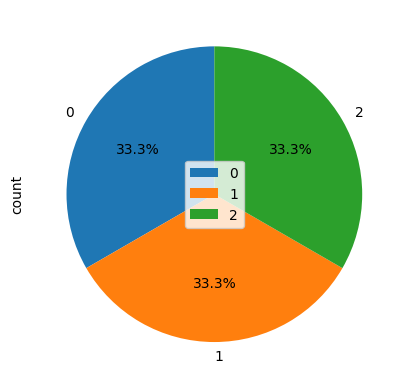

In [49]:
data_plot = Plot_Signals(data, n_classes)
data_plot.df_num_classes(name_cat)

del data_plot

# Declaration and training of the SVM model

In [51]:
# "SVM_Model_Classifier" Instance
SVM_model = SVM_Model_Classifier(kernel = kernel,
                                 C = C, 
                                 random_state = random_state, 
                                 etiq_list = etiq_list)                      
SVM_model.create_svm_model()                                                                                                     

Train model with KFolds

In [ ]:

# k -> No. of folds
k = 5                                                                                                                             
kfold = KFold(n_splits = k, shuffle = True)

# Taking starting time                                                                                  
start_time = time.time()

# Iterate over the folds generated by StratifiedKFold
for train_index, test_index in kfold.split(X, Y):
    # Split the data into training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Train and evaluate the model on each fold
    SVM_model.train_svm_model_kf(X_train, Y_train, X_test, Y_test)

# Taking ending time
end_time = time.time()                                                                                                      

# Total training time
training_time = end_time - start_time                                                                                 

# Print training time
print("Training time: {:.2f} seconds".format(training_time))

Load trained SVM model

In [ ]:
SVM_model.clf = load(svm_model_path)          

Save trained model

In [ ]:
save_svm_name = 'svm_model.joblib'
dump(SVM_model.clf, os.getcwd(), 'SVM_model') + '\\' + save_svm_name)

Splitting data with train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = random.seed())

Hyperparameter search with GridSearch

In [ ]:
SVM_model.model_gridsearchcv_svm(parameters_svm, cv, X_test, Y_test)
SVM_model.best_gridsearch_result_svm()

Evaluate model with sample data

In [ ]:
SVM_model.sample_predict_svm(X_test)                                                                                         
SVM_model.count_samples_predictions()                                                                             

y_test_onehot = label_binarize(Y_test, classes = etiq_list)
y_pred_onehot = label_binarize(SVM_model.svm_predictions, classes = etiq_list)

cm = confusion_matrix(y_test_onehot.argmax(axis=1), y_pred_onehot.argmax(axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predictions')
plt.ylabel('Real Value')
plt.title('Confusion Matrix')
plt.show()

# User interface functions (Google Colab)

In [42]:
# Model functions

# Read EDF Files
def read_edf(path: str):
  raw_data = mne.io.read_raw_edf(path)                                                                          
  ch_names = raw_data.info['ch_names']
  rdata, times = raw_data.get_data(return_times=True)
  rdata = pd.DataFrame(rdata.T)
  rdata.columns = ch_names     
  return rdata

# Average Recurrence
def get_average_recurrence():
  num_sets = (eval_df.T.shape[1]) // 256
  external_internal_values = []
  limit = 0.00010

  # Evaluating each set in the sample
  for i in range(num_sets):
    # Range
    start_col = i * frequency_sample
    end_col = (i + 1) * frequency_sample
    
    # Select the highest value in the 256 set
    max_value = np.max(pd.DataFrame(eval_df.T.mean()).T.iloc[0, start_col:end_col])
    # Select the minimum value in the 256 set                             
    min_value = np.min(pd.DataFrame(eval_df.T.mean()).T.iloc[0, start_col:end_col])                             
    
    # If value is higher than limit is a peak, otherwise it's not taken
    if(max_value > limit):                                                                                    
      external_internal_values.append(1) # External
    elif (min_value < (limit*-1)):                                                              
      external_internal_values.append(1) # External
    else:
      pass
      # external_internal_values.append(0) # Internal

  count_1 = external_internal_values.count(1) # External
  # count_0 = external_internal_values.count(0) # Internal

  avg_percent = "{:.2f}".format(((count_1/2)/30)*100)
  return avg_percent

# Individual recurrence (Per channel)
def get_recurrence_pc():
  num_sets_per_ch = (eval_df.T.shape[1]) // 256                                                                 

  # Max and min value
  max_value = []
  min_value = []

  # Recurrence variables: Counting and Channels
  recurrence = 0                                                                                               
  ch_recurrence = []                                                                                

  # Evaluate data
  df = eval_df.T

  # Buscar el valor mas alto entre los canales con su indice
  max_values = df.max(axis=1)
  max_index = max_values.idxmax()

  # Buscar el valor mas bajo entre los canales con su indice
  min_values = df.min(axis=1)
  min_index = min_values.idxmin()

  # Busqueda del max y minimo del canal
  for i in range(num_sets_per_ch):
    start_col = i * 256
    end_col = (i + 1) * 256
    df_aux_max = pd.DataFrame(eval_df.T.loc[max_index]).iloc[start_col:end_col]
    df_aux_min = pd.DataFrame(eval_df.T.loc[min_index]).iloc[start_col:end_col]

    max_value.append(df_aux_max.max(axis=0))
    min_value.append(df_aux_min.min(axis=0))

  # Promedio de los max y minimos de ese canal
  mean_max = sum(max_value)/len(max_value)
  mean_min = sum(min_value)/len(min_value)

  # Buscar los valores que pasen el maximo y minimo cada 256 valores
  for channel in range(n_channels):
    # Listas con max y minimos
    max_values_in_fs = []
    min_values_in_fs = []

    for i in range(num_sets_per_ch):
      start_col = i * 256
      end_col = (i + 1) * 256
      df_aux = pd.DataFrame(eval_df.T.iloc[channel]).iloc[start_col:end_col]
      max_value_in_ch = df_aux.max(axis=0)
      min_value_in_ch = df_aux.min(axis=0)
      if(float(max_value_in_ch) > float(mean_max)):
        max_values_in_fs.append(1)
      else:
        max_values_in_fs.append(0)

      if(float(min_value_in_ch) < float(mean_min)):
        max_values_in_fs.append(1)
      else:
        max_values_in_fs.append(0)

    count_1 = max_values_in_fs.count(1)
    count_0 = max_values_in_fs.count(0)
    recurrence_perc = ((count_1/2)/num_sets_per_ch)*100
    if(recurrence_perc >= 40.0):
      recurrence+=1
      ch_recurrence.append(eval_df.T.index[channel])
  return recurrence, ch_recurrence

# Funciones UI

# ------------------------------------------------------------------- Other functions ---------------------------------------------------------
def update_range_eval(change):
  range_eval_end.value = range_eval_start.value + nperseg

# ----------------------------------------------------------------- LOAD MODEL & WEIGHT -------------------------------------------------------
def on_click_train_model(button):
  if buttons_gr.children:
    buttons_gr.children = ()
  else:
    buttons_gr.children = (widgets.HBox([load_weight_button, load_model_button], layout=widgets.Layout(justify_content='center')),)

def on_click_load_weight_button(button):
  # Variables globales
  global model_cnn_path

  # Modelo CNN
  model_cnn_path = cnn_model_path

  # Mostrar la gráfica en el widget de salida
  output_widget = widgets.Output()
  with output_widget:
    text = widgets.HTML('<h1 style="text-align: center;font-family:Helvetica;margin:100px 0 0 0;font_weight:bold">¡Pesos cargados exitosamente!</h1>')
    image = widgets.Image(value=open('/content/drive/MyDrive/Tesis/Imagenes/visto-bueno.jpg', 'rb').read(),
                          format='jpg', layout= widgets.Layout(width='30px', height='30px', margin = '100px 5px 0 0'))
    output_widget = widgets.HBox([image, text])

  # Actualizar el contenido del contenedor buttons_gr
  output_widget_box = widgets.HBox([output_widget], layout=widgets.Layout(justify_content='center'))
  buttons_gr.children = (widgets.HBox([load_weight_button, load_model_button]), output_widget_box)

def on_click_load_model_button(button):
  # Variables globales
  global SVM_model

  # Modelo SVM
  SVM_model = SVM_Model_Classifier(kernel = kernel, C = C, random_state = random_state, etiq_list = etiq_list)
  SVM_model.create_svm_model()
  SVM_model.clf = load(svm_model_path)

  # Mostrar la gráfica en el widget de salida
  output_widget = widgets.Output()
  with output_widget:
    text = widgets.HTML('<h1 style="text-align: center;font-family:Helvetica;margin:100px 0 0 0;font_weight:bold">¡Modelo exitosamente!</h1>')
    image = widgets.Image(value=open('/content/drive/MyDrive/Tesis/Imagenes/visto-bueno.jpg', 'rb').read(),
                          format='jpg', layout= widgets.Layout(width='30px', height='30px', margin = '100px 5px 0 0'))
    output_widget = widgets.HBox([image, text])

  # Actualizar el contenido del contenedor buttons_gr
  output_widget_box = widgets.HBox([output_widget], layout=widgets.Layout(justify_content='center'))
  buttons_gr.children = (widgets.HBox([load_weight_button, load_model_button]), output_widget_box)


# --------------------------------------------------------------------- PLOTTING ------------------------------------------------------------------------------
def on_click_grafica(button):
  if buttons_gr.children:
    buttons_gr.children = ()
  else:
    buttons_gr.children = (widgets.HBox([plot_dt_button, plot_df_button, plot_mean_button], layout=widgets.Layout(justify_content='center')),)

def on_click_plot_dt(button):

  if len(buttons_gr.children) > 1:
    buttons_gr.children = (buttons_gr.children[0],)
  else:
    # Mostrar la gráfica en el widget de salida
    output_widget = widgets.Output()
    with output_widget:
      plot_csv = Plot_Signals(eval_df, etiq_list)
      plot_csv.dom_temp(0, 7680, 4)
      plt.show()

    # Actualizar el contenido del contenedor buttons_gr
    output_widget_box = widgets.HBox([output_widget], layout=widgets.Layout(justify_content='center', margin = '30px 0 0 0'))
    buttons_gr.children = (widgets.HBox([plot_dt_button, plot_df_button, plot_mean_button]), output_widget_box)

def on_click_plot_df(button):

  if len(buttons_gr.children) > 1:
    buttons_gr.children = (buttons_gr.children[0],)
  else:
    output_widget = widgets.Output()
    with output_widget:
      plot_df = Plot_Signals(data_domf.T, etiq_list)
      plot_df.dom_frec(frequency_range, plot_class = 4)
      plt.show()

    # Actualizar el contenido del contenedor buttons_gr
    output_widget_box = widgets.HBox([output_widget], layout=widgets.Layout(justify_content='center', margin = '30px 0 0 0'))
    buttons_gr.children = (widgets.HBox([plot_dt_button, plot_df_button, plot_mean_button]), output_widget_box)

def on_click_plot_mean(button):

  if len(buttons_gr.children) > 1:
    buttons_gr.children = (buttons_gr.children[0],)
  else:
    output_widget = widgets.Output()
    with output_widget:
      plot_mean = Plot_Signals(eval_df.T.mean(), etiq_list)
      plot_mean.mean_dom_temp(4)
      plt.show()

    # Actualizar el contenido del contenedor buttons_gr
    output_widget_box = widgets.HBox([output_widget], layout=widgets.Layout(justify_content='center', margin = '30px 0 0 0'))
    buttons_gr.children = (widgets.HBox([plot_dt_button, plot_df_button, plot_mean_button]), output_widget_box)


# ------------------------------------------------------------------- INSERT EEG EDF -----------------------------------------------------------------
def on_click_insert_eeg(button):
  # Variables globales
  global text_path
  global range_eeg_start
  global range_eeg_end

  if buttons_gr.children:
    buttons_gr.children = ()
  else:
    # Widgets
    insert_button = widgets.Button(description='Cargar EEG', button_style='info', layout=widgets.Layout(width='30%', height = '35px', margin='20px auto'))
    range_eeg_start = widgets.IntText(description='Valor inicial:', layout=widgets.Layout(width='30%', margin='10px 15px 0 0'))
    range_eeg_start.style.description_width = 'auto'
    range_eeg_end = widgets.IntText(description='Valor final:', layout=widgets.Layout(width='30%', margin='10px 0 0 15px'))
    range_eeg_end.style.description_width = 'auto'
    range_eeg_box = widgets.HBox([range_eeg_start, range_eeg_end], layout=widgets.Layout(justify_content='center'))
    text_path = widgets.Text(description='Ruta del EEG en formato EDF:', layout=widgets.Layout(width='90%', height = '20px', margin = '0 0 20px'))
    text_path.style.description_width = 'auto'
    buttons_gr.children = (widgets.VBox([text_path, range_eeg_box, insert_button]),)

    # Eventos
    insert_button.on_click(on_click_load_weight_path)

def on_click_load_weight_path(button):
  # Variables globales
  global signal_eeg

  # Modelo
  reading_edf = pd.DataFrame(read_edf(text_path.value))
  signal_eeg = reading_edf[range_eeg_start.value:range_eeg_end.value].reset_index(drop=True)

  output_widget = widgets.Output()
  with output_widget:
    text = widgets.HTML('<h1 style="text-align: center;font-family:Helvetica;margin:40px 0 0 0;font_weight:bold">¡Electroencefalograma cargado exitosamente!</h1>')
    image = widgets.Image(value=open('/content/drive/MyDrive/Tesis/Imagenes/visto-bueno.jpg', 'rb').read(), format='jpg',
                          layout= widgets.Layout(width='30px', height='30px', margin = '40px 5px 0 0'))
    output_widget = widgets.HBox([image, text])

  # Actualizar el contenido del contenedor buttons_gr
  output_widget_box = widgets.HBox([output_widget], layout=widgets.Layout(justify_content='center'))
  children = buttons_gr.children[0].children
  children = children[:3] + (output_widget_box,)
  buttons_gr.children[0].children = children


# --------------------------------------------------- PREDICTION --------------------------------------------------------------------
def on_click_predict_sample(button):
  # Variables globales
  global range_eval_start
  global range_eval_end

  if buttons_gr.children:
    buttons_gr.children = ()
  else:
    samples_qty = range_eeg_end.value-range_eeg_start.value
    label_samples = widgets.HTML('<h1 style="text-align: center;font-family:Helvetica;font_weight:bold">Total de muestras seleccionadas</h1>')
    total_samples = widgets.IntText(value = samples_qty, layout=widgets.Layout(width='300px', margin='20px 0 10px 0'), disabled = True)
    centered_box = widgets.HBox([total_samples], layout=widgets.Layout(justify_content='center'))
    v_samples_box = widgets.VBox([label_samples, centered_box], layout=widgets.Layout(align_items='center'))
    label_text = widgets.HTML('<h1 style="text-align: center;font-family:Helvetica;font_weight:bold">Rango a evaluar</h1>')
    range_eval_start = widgets.IntText(description='Valor inicial a evaluar:', layout=widgets.Layout(width='30%', margin='10px 15px 0 0'))
    range_eval_start.style.description_width = 'auto'
    range_eval_end = widgets.IntText(value = nperseg,description='Valor final a evaluar:', layout=widgets.Layout(width='30%', margin='10px 0 0 15px'), disabled = True)
    range_eval_start.observe(update_range_eval, 'value')
    range_eval_end.style.description_width = 'auto'
    range_eval_hbox = widgets.HBox([range_eval_start, range_eval_end], layout=widgets.Layout(justify_content='center'))
    eval_button = widgets.Button(description='Evaluar EEG', button_style='info', layout=widgets.Layout(width='30%', height = '35px', margin='20px auto'))
    buttons_gr.children = (widgets.VBox([v_samples_box, label_text, range_eval_hbox, eval_button], layout=widgets.Layout(justify_content='center')),)

    eval_button.on_click(on_click_eval_button)

def on_click_eval_button(button):
  # Variables globales
  global eval_df
  global ext_data_prep_df
  global frequency_range
  global data_domf
  global perc_pre
  global perc_ict
  global perc_oth

  eval_df = signal_eeg[range_eval_start.value:range_eval_end.value]

  # Transformada de fourier
  ext_data_df = Setting_Data_Domf(df = eval_df, n_channels = n_channels, frequency_sample = frequency_sample, nperseg = nperseg, noverlap = noverlap)
  data_domf = np.abs(ext_data_df.apply_stft_one_set())
  frequency_range = ext_data_df.freq

  # Escalamiento
  ext_data_prep_df = Preprocessing_Datasets(df = data_domf, x_type = 'float32')                             # Declarando el objeto de preprocesamiento
  ext_data_prep_df.formatting_x()                                                                             # Pasando a ndarray y cambiando el tipo a float32
  ext_data_prep_df.robust_formatting()

  # Modelo CNN
  domf_model = CNN_Feature_Extractor([ext_data_prep_df.X.shape[1], ext_data_prep_df.X.shape[2]])              # Declaración del modelo y asignando el input shape
  domf_model.feature_extractor()
  domf_model.model.load_weights(model_cnn_path)

  # Extraccion caracteristicas
  ext_X = domf_model.model.predict(ext_data_prep_df.X)                                                        # Extracción de características

  # Clasificación
  SVM_model.sample_predict_svm(ext_X)                                                                         # Clasificación modelo SVM
  SVM_model.count_samples_predictions()                                                                       # Conteo de predicciones

  perc_pre = (SVM_model.dict_count[0]/ext_data_prep_df.X.shape[0])
  perc_ict = (SVM_model.dict_count[1]/ext_data_prep_df.X.shape[0])
  perc_oth = (SVM_model.dict_count[2]/ext_data_prep_df.X.shape[0])

  # Mostrar la gráfica en el widget de salida
  output_widget = widgets.Output()
  with output_widget:
    line_html = widgets.HTML('<hr style="border: 0; height: 1px; background-color: #000; margin-bottom: 25px;">')
    label_text_pred = widgets.HTML('<h1 style="text-align: center;font-family:Helvetica"> Resultados de predicción</h1>')
    result_pred_0 = widgets.Text(value = "{:.2%}".format(perc_pre), description='Preictal', layout=widgets.Layout(width='30%', margin='10px 0 0 15px'), disabled = True)
    result_pred_1 = widgets.Text(value = "{:.2%}".format(perc_ict), description='Ictal:', layout=widgets.Layout(width='30%', margin='10px 0 0 15px'), disabled = True)
    result_pred_2 = widgets.Text(value = "{:.2%}".format(perc_oth), description='Otros datos', layout=widgets.Layout(width='30%', margin='10px 0 0 15px'), disabled = True)
    box_horizontal = widgets.HBox([result_pred_0, result_pred_1, result_pred_2], layout=widgets.Layout(justify_content='center'))
    output_widget = widgets.VBox([line_html, label_text_pred, box_horizontal], layout=widgets.Layout(justify_content='center'))

  children = buttons_gr.children[0].children
  children = children[:3] + (output_widget,)
  buttons_gr.children[0].children = children

# --------------------------------------------------------------------- FINAL RESULT ---------------------------------------------------------------------------------------

def on_click_final_result(button):
  if buttons_gr.children:
    buttons_gr.children = ()
  else:
    label_text_pred = widgets.HTML('<h1 style="text-align: center;font-family:Helvetica"> Resultados de predicción</h1>')
    result_pred_0 = widgets.Text(value = "{:.2%}".format(perc_pre), description='Preictal', layout=widgets.Layout(width='30%', margin='10px 0 0 15px'), disabled = True)
    result_pred_1 = widgets.Text(value = "{:.2%}".format(perc_ict), description='Ictal:', layout=widgets.Layout(width='30%', margin='10px 0 0 15px'), disabled = True)
    result_pred_2 = widgets.Text(value = "{:.2%}".format(perc_oth), description='Otros datos', layout=widgets.Layout(width='30%', margin='10px 0 0 15px'), disabled = True)
    box_horizontal = widgets.HBox([result_pred_0, result_pred_1, result_pred_2], layout=widgets.Layout(justify_content='center'))

    float_recurrence_mean = widgets.FloatText(value= get_average_recurrence(), description='Recurrencia de los picos con los canales promediados:',
                                              disabled=True, layout=widgets.Layout(justify_content='center', margin = '40px auto', width = '70%'))
    float_recurrence_mean.style.description_width = 'auto'

    qty_recurrence, ch_names = get_recurrence_pc()
    int_recurrence_pc = widgets.IntText(value = qty_recurrence, description='Cantidad de canales con recurrencia mayor a 40%:', disabled=True,
                                        layout=widgets.Layout(justify_content='center', margin = '0 40px 0 0', width = '35%'))
    int_recurrence_pc.style.description_width = 'auto'
    ch_w_recurrences = widgets.Select(options=ch_names, description='Canales con recurrencia', disabled=True, layout=widgets.Layout(justify_content='center', width = '40%'))
    ch_w_recurrences.style.description_width = 'auto'
    qty_and_ch_box = widgets.HBox([int_recurrence_pc, ch_w_recurrences], layout=widgets.Layout(justify_content='center'))
    line_html = widgets.HTML('<hr style="border: 0; height: 1px; background-color: #000; margin-bottom: 15px;margin-top:15px">')
    title_html = widgets.HTML('<h1 style="text-align: center;font-family: Helvetica; margin-bottom:25px">Resultado final del modelo.</h1>')

    data_total = SVM_model.dict_count[1]+SVM_model.dict_count[2]+SVM_model.dict_count[0]
    results = []

    # Resultados etapa ictal
    if((SVM_model.dict_count[1] > SVM_model.dict_count[0] and SVM_model.dict_count[1] > SVM_model.dict_count[2] and float_recurrence_mean.value > 10.0)
        or (float_recurrence_mean.value > 10.0 and int_recurrence_pc.value > 1)):

      accuracy = SVM_model.dict_count[1] / data_total
      results.append(f'- Del total de los datos ({(data_total/data_total)*100}%):')
      results.append(f'- Se clasificó la etapa ictal con un {(accuracy*100):.2f}% / La etapa preictal con un {(SVM_model.dict_count[0]/data_total)*100:.2f}% / Otros datos con un {(SVM_model.dict_count[2]/data_total)*100:.2f}%.')
      if(float_recurrence_mean.value > 10.0):
        results.append(f'- Existe una recurrencia en los picos promediados a lo largo de los 30 segundos de {float_recurrence_mean.value:.2f}%.')
      if(int_recurrence_pc.value > 1):
        results.append(f'- Existe una recurrencia mayor de 40% en {int_recurrence_pc.value} canales, lo que puede significar una epilepsia focal.')
      results.append('Resultado: Etapa ictal')

    # Resultados etapa preictal
    elif((SVM_model.dict_count[0] > SVM_model.dict_count[1] and SVM_model.dict_count[0] > SVM_model.dict_count[2])
         or (float_recurrence_mean.value < 10.00 and SVM_model.dict_count[0] > SVM_model.dict_count[2] and int_recurrence_pc.value < 2)):

      accuracy = SVM_model.dict_count[0] / data_total
      if(SVM_model.dict_count[0] > SVM_model.dict_count[1] and SVM_model.dict_count[0] > SVM_model.dict_count[2]):
        results.append(f'- Del total de los datos ({(data_total/data_total)*100}%):')
        results.append(f'- En la clasificación predomina la etapa preictal con un {(accuracy*100):.2f}% / La etapa ictal {((SVM_model.dict_count[1]/data_total)*100):.2f}% / Otros datos {((SVM_model.dict_count[2]/data_total)*100):.2f}%.')
        if(float_recurrence_mean.value < 10.00):
          results.append(f'- Existe una recurrencia en los picos promediados a lo largo de los 30 segundos de {float_recurrence_mean.value:.2f}%.')
        if(int_recurrence_pc.value < 2):
          results.append(f'- Existe una recurrencia mayor a 40% en {int_recurrence_pc.value} de sus canales.')
        results.append('Resultado: Etapa preictal')
      elif(float_recurrence_mean.value < 10.00 and SVM_model.dict_count[0] > SVM_model.dict_count[2] and int_recurrence_pc.value < 2):
        results.append(f'- Del total de los datos ({(data_total/data_total)*100}%):')
        results.append(f'- Se clasificó la etapa preictal con un {(accuracy*100):.2f}% / La etapa ictal {((SVM_model.dict_count[1]/data_total)*100):.2f}% / Otros datos {((SVM_model.dict_count[2]/data_total)*100):.2f}%.')
        if(float_recurrence_mean.value < 10.00):
          results.append(f'- Existe una recurrencia en los picos promediados a lo largo de los 30 segundos de {float_recurrence_mean.value:.2f}%.')
        if(int_recurrence_pc.value < 2):
          results.append(f'- Existe una recurrencia mayor a 40% en {int_recurrence_pc.value} de sus canales.')
        results.append('Resultado: Etapa preictal')

    # Resultados otras etapas
    elif((SVM_model.dict_count[2] > SVM_model.dict_count[0] and float_recurrence_mean.value < 2.0)
        or (float_recurrence_mean.value < 2.0 and int_recurrence_pc.value > 1 and SVM_model.dict_count[1] > SVM_model.dict_count[0])):

      accuracy = SVM_model.dict_count[2] / data_total
      results.append(f'- Del total de los datos ({(data_total/data_total)*100}%):')
      results.append(f'- En la clasificación predomina la categoria Otros datos con un {(accuracy*100):.2f}% / La etapa preictal con un {((SVM_model.dict_count[0]/data_total)*100):.2f}% / Descartando la etapa ictal que tiene un porcentaje de {((SVM_model.dict_count[1]/data_total)*100):.2f}%.')
      if(SVM_model.dict_count[1] > SVM_model.dict_count[0] and SVM_model.dict_count[1] > SVM_model.dict_count[2]):
        results.append(f'- Los resultados obtenidos del modelo apuntan a que la mayoria de los canales tienen un comportamiento similar a una etapa Ictal.')
        results.append(f'- Sin embargo, hubo una recurrencia de los picos a lo largo de los 30 segundos de {float_recurrence_mean.value:.2f}%, por lo que se descarta una etapa ictal y puede ser un posible preictal.')
      results.append('Resultado: Otros datos')
    else:
      results.append('No se pudo clasificar, resultados ambiguos')
    result_widget = widgets.SelectMultiple(options=results, disabled=True, layout=widgets.Layout(justify_content='center', width = 'auto'))
    buttons_gr.children = (widgets.VBox([label_text_pred, box_horizontal, float_recurrence_mean, qty_and_ch_box, line_html, title_html, result_widget], layout=widgets.Layout(justify_content='center')),)


# Cuerpo interfaz de usuario

In [43]:
# Apartado: TITULO
title_html = widgets.HTML('<h1 style="text-align: center;font-family: Helvetica">ANÁLISIS DE ELECTROENCEFALOGRAFÍA</h1>')
line_html = widgets.HTML('<hr style="border: 0; height: 1px; background-color: #000; margin-bottom: 25px;">')


# Apartado: ENTRENAMIENTO DE MODELO
# --- BOTONES ---
train_model_button = widgets.Button(description='Cargar modelo', button_style='info', layout=widgets.Layout(width='90%', height = '45px', margin = 'auto 0px 20px 0'), style=dict(
    font_weight='bold'
))
load_weight_button = widgets.Button(description='Cargar pesos del CNN', button_style = 'primary', layout=widgets.Layout(flex = '1', width='25%', height = '45px', margin = '0 15px 0 0'), style=dict(font_weight='bold'))
load_model_button = widgets.Button(description='Cargar modelo SVM', button_style = 'primary', layout=widgets.Layout(flex = '1', width='25%', height = '45px', margin = '0 0 0 15px'), style=dict(font_weight='bold'))

# --- EVENTOS ---
train_model_button.on_click(on_click_train_model)
load_weight_button.on_click(on_click_load_weight_button)
load_model_button.on_click(on_click_load_model_button)

# Apartado: INSERTAR EEG
# --- BOTONES ---
insert_eeg_button = widgets.Button(description='Insertar EEG', button_style='info', layout=widgets.Layout(width='90%', height = '45px', margin = 'auto 0px 20px 0'), style=dict(
    font_weight='bold'
))

# --- EVENTOS ---
insert_eeg_button.on_click(on_click_insert_eeg)

# Apartado: PREDICCIONES
# --- BOTONES ---
predict_button = widgets.Button(description='Predecir EEG', button_style='info', layout=widgets.Layout(width='90%', height = '45px', margin = 'auto 0px 20px 0'), style=dict(
    font_weight='bold'
))

# --- EVENTOS ---
predict_button.on_click(on_click_predict_sample)

# Apartado: GRAFICAS
# --- BOTONES ---
plotting_button = widgets.Button(description='Graficar EEG', button_style='info', layout=widgets.Layout(width='90%', height = '45px', margin = 'auto 0px 20px 0'), style=dict(font_weight='bold'))
plot_dt_button = widgets.Button(description='Dominio temporal', button_style = 'primary', layout=widgets.Layout(flex = '1', width='25%', height = '45px'))
plot_df_button = widgets.Button(description='Espectrograma', button_style = 'primary', layout=widgets.Layout(flex = '1', width='25%', height = '45px'))
plot_mean_button = widgets.Button(description='Promedio de canales', button_style = 'primary', layout=widgets.Layout(flex = '1', width='25%', height = '45px'))

# --- EVENTOS ---
plotting_button.on_click(on_click_grafica)
plot_dt_button.on_click(on_click_plot_dt)
plot_df_button.on_click(on_click_plot_df)
plot_mean_button.on_click(on_click_plot_mean)

# Apartado: RESULTADO FINAL
# --- BOTONES ---
final_result_button = widgets.Button(description='Resultado final', button_style='info', layout=widgets.Layout(width='90%', height = '45px', margin = 'auto 0px 20px 0'), style=dict(font_weight='bold'))

# --- EVENTOS ---
final_result_button.on_click(on_click_final_result)

# CONTENEDORES
buttons_left = widgets.VBox([train_model_button, insert_eeg_button, predict_button, plotting_button, final_result_button])
buttons_gr = widgets.VBox([])
grid_layout = widgets.GridBox([buttons_left, buttons_gr], layout=widgets.Layout(grid_template_columns='30% 70%', padding='25px'))



# Mostrar inferfaz de usuario

Tabla descriptiva

In [44]:
time_stamp = pd.read_csv(time_stamp_path)
time_stamp[['Patient','Sub File' ,'No of channels', 'Ictal Start Row', 'Ictal End Row', 'Pre Ictal Start Row', 'Pre Ictal End Row']]

,Patient,Sub File,No of channels,Ictal Start Row,Ictal End Row,Pre Ictal Start Row,Pre Ictal End Row
0,1,chb01_03,23,766976,777216,755456,765696
1,1,chb01_04,23,375552,382464,367360,374272
2,1,chb01_15,23,443392,453632,431872,442112
3,1,chb01_16,23,259840,272896,245504,258560
4,1,chb01_18,23,440320,463360,416000,439040
...,...,...,...,...,...,...,...
192,24,chb24_13,23,841728,845824,836352,840448
193,24,chb24_14,23,496384,503296,488192,495104
194,24,chb24_15,23,909312,913664,903680,908032
195,24,chb24_17,23,899840,916736,881664,898560


In [45]:
# Mostrar el título en la interfaz
display(title_html, line_html, grid_layout)

# /content/drive/MyDrive/Tesis/Codigo/Datasets/CHB/Seizures/chb24_17.edf
# /content/drive/MyDrive/Tesis/Codigo/Datasets/CHB/Seizures/chb24_21.edf

HTML(value='<h1 style="text-align: center;font-family: Helvetica">ANÁLISIS DE ELECTROENCEFALOGRAFÍA</h1>')

HTML(value='<hr style="border: 0; height: 1px; background-color: #000; margin-bottom: 25px;">')

GridBox(children=(VBox(children=(Button(button_style='info', description='Cargar modelo', layout=Layout(height…